<a href="https://colab.research.google.com/github/Sofismarilla/PatientVisitsForecasting/blob/main/PROPHET_Patient_Visits_Forecasting_for_Allocation_Decision_of_Healthcare_%5BGroupTestB%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multivariate Time Series Forecasting using Prophet Model based on Patient Visits Medical Laboratory Data (GroupTestB)**

## **Step#0 Fire System**

In [1]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn
!pip install statsmodels
!pip install --user scipy==1.2.0
!pip install -U statsmodels

     |████████████████████████████████| 1.5MB 6.5MB/s 
     |████████████████████████████████| 9.5MB 12.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 358kB 6.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491628 sha256=eb63f4b8c83c042a459f08505953ccc64cc4b036bc518172fd0d8cd965d6b5c6
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 46.9MB 64kB/s 
     |████████████████████████████████| 901kB 30.3MB/s 
     |████████████████████████████████| 10.1MB 30.9MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 7.1MB 5.1MB/s 
ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1, b

In [3]:
import warnings
import numpy as np
import pandas as pd

# Data visualization
import folium
import datetime
%matplotlib inline
import seaborn as sns 
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython.display import display, HTML, display_html

# Method Requirement
import keras
import sklearn
import tensorflow as tf
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Statistics 
import scipy
from math import sqrt
from time import time
from scipy import stats
import statsmodels as sms
from timeit import default_timer as timer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('white')
warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = False
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## **Step#1 Input Data**

In [4]:
data = pd.read_csv('/content/drive/MyDrive/THESIS/Dataset/dateset_patient.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1348 non-null   object
 1   hm        1348 non-null   int64 
 2   hm_aw     1348 non-null   int64 
 3   hm_am     1348 non-null   int64 
 4   cc        1348 non-null   int64 
 5   cc_aw     1348 non-null   int64 
 6   cc_am     1348 non-null   int64 
 7   day_week  1348 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 84.4+ KB


In [6]:
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
data['weekday']= data.apply(lambda row: row['date'].weekday(),axis=1)
data['weekday'] = (data["weekday"] < 5).astype(int)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1348 non-null   datetime64[ns]
 1   hm        1348 non-null   int64         
 2   hm_aw     1348 non-null   int64         
 3   hm_am     1348 non-null   int64         
 4   cc        1348 non-null   int64         
 5   cc_aw     1348 non-null   int64         
 6   cc_am     1348 non-null   int64         
 7   day_week  1348 non-null   int64         
 8   weekday   1348 non-null   int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 94.9 KB


In [8]:
data.head()

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week,weekday
0,2017-07-01,66,48,63,44,37,45,6,0
1,2017-07-02,53,53,62,72,37,43,7,0
2,2017-07-03,74,54,59,87,42,44,1,1
3,2017-07-04,87,56,57,58,49,44,2,1
4,2017-07-05,95,62,58,72,53,44,3,1


## **Step#2 Data Processing**

### **Picking Variable**

In [9]:
multi_prophet_df = data.reset_index()[['date', 'cc', 'cc_aw', 'cc_am', 'weekday', ]].rename({'date': 'ds', 'cc':'y','cc_aw': 'aw', 'cc_am': 'am', 'weekday': 'wd', })

In [10]:
multi_prophet_df

,date,cc,cc_aw,cc_am,weekday
0,2017-07-01,44,37,45,0
1,2017-07-02,72,37,43,0
2,2017-07-03,87,42,44,1
3,2017-07-04,58,49,44,1
4,2017-07-05,72,53,44,1
...,...,...,...,...,...
1343,2021-03-05,37,42,38,1
1344,2021-03-06,33,42,38,0
1345,2021-03-07,36,41,38,0
1346,2021-03-08,47,40,39,1


In [12]:
multi_prophet_df = pd.DataFrame({'ds': multi_prophet_df.date,
                                 'y' : multi_prophet_df.cc,
                                 'aw' : multi_prophet_df.cc_aw,
                                 'am' : multi_prophet_df.cc_am,
                                 'wd' : multi_prophet_df.weekday})

In [ ]:
multi_prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348 entries, 0 to 1347
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1348 non-null   datetime64[ns]
 1   y       1348 non-null   int64         
 2   aw      1348 non-null   int64         
 3   am      1348 non-null   int64         
 4   wd      1348 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 63.2 KB


In [13]:
multi_prophet_df.head()

,ds,y,aw,am,wd
0,2017-07-01,44,37,45,0
1,2017-07-02,72,37,43,0
2,2017-07-03,87,42,44,1
3,2017-07-04,58,49,44,1
4,2017-07-05,72,53,44,1


In [14]:
def wd(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0

### **Stationary Test**

In [15]:
df = multi_prophet_df.loc[:,['y','am','aw','wd']]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348 entries, 0 to 1347
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       1348 non-null   int64
 1   am      1348 non-null   int64
 2   aw      1348 non-null   int64
 3   wd      1348 non-null   int64
dtypes: int64(4)
memory usage: 52.7 KB


In [17]:
#creating test for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationary(df):

  #Perform Dicky Fuller Test:
  print ('Result of Dicky-Fuller Test:')
  dftest = adfuller(df, autolag='AIC')
  dfoutput = pd.Series(df[0:4], 
                       index=['Test Statistic','p-value','#Lags Used',
                              'Number of Observations Used'])
  
  for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

In [18]:
#Loop to check all columns of the DF
import functools
df.apply(functools.partial(test_stationary))

Result of Dicky-Fuller Test:
Test Statistic                    nan
p-value                           nan
#Lags Used                        nan
Number of Observations Used       nan
Critical Value (1%)           -3.4353
Critical Value (5%)           -2.8637
Critical Value (10%)          -2.5679
Name: y, dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                    nan
p-value                           nan
#Lags Used                        nan
Number of Observations Used       nan
Critical Value (1%)           -3.4353
Critical Value (5%)           -2.8637
Critical Value (10%)          -2.5679
Name: am, dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                    nan
p-value                           nan
#Lags Used                        nan
Number of Observations Used       nan
Critical Value (1%)           -3.4353
Critical Value (5%)           -2.8637
Critical Value (10%)          -2.5679
Name: aw, dtype: float64
Result of Dicky-Fuller Test:
Test Statist

y     None
am    None
aw    None
wd    None
dtype: object

### **Differencing**

In [19]:
df_diff = df.diff().dropna()
df_diff

,y,am,aw,wd
1,28.0000,-2.0000,0.0000,0.0000
2,15.0000,1.0000,5.0000,1.0000
3,-29.0000,0.0000,7.0000,0.0000
4,14.0000,0.0000,4.0000,0.0000
5,-13.0000,0.0000,5.0000,0.0000
...,...,...,...,...
1343,-2.0000,0.0000,2.0000,0.0000
1344,-4.0000,0.0000,0.0000,-1.0000
1345,3.0000,0.0000,-1.0000,0.0000
1346,11.0000,1.0000,-1.0000,1.0000


### **Splitting Data**

In [20]:
#creating the train and validation set
train = multi_prophet_df[:int(0.8*(len(df_diff)))]
test = multi_prophet_df[int(0.8*(len(df_diff))):]

## **Step#3 Fitting and Training Model**

In [21]:
from fbprophet import Prophet

mProp = Prophet(interval_width=0.95, daily_seasonality=True)
mProp.fit(multi_prophet_df)

## **Step#4 Actual vs Prediction Plot and Evaluation Metrics**

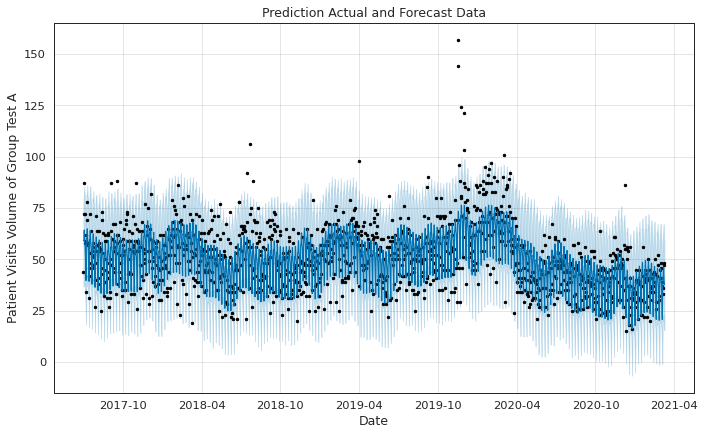

In [22]:
future = mProp.make_future_dataframe(periods=1) #we need to specify the number of days in future
prediction = mProp.predict(future)
mProp.plot(prediction)
plt.title("Prediction Actual and Forecast Data")
plt.xlabel("Date")
plt.ylabel("Patient Visits Volume of Group Test A")
plt.show()

In [23]:
forecast = mProp.predict(test.drop(columns="y"))
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-12,41.5924,3.1769,47.2176,41.5924,41.5924,-16.4604,-16.4604,-16.4604,7.7243,7.7243,7.7243,-15.9396,-15.9396,-15.9396,-8.2451,-8.2451,-8.2451,0.0000,0.0000,0.0000,25.1320
1,2020-06-13,41.5180,24.3195,68.6233,41.5180,41.5180,4.4188,4.4188,4.4188,7.7243,7.7243,7.7243,4.5581,4.5581,4.5581,-7.8637,-7.8637,-7.8637,0.0000,0.0000,0.0000,45.9368
2,2020-06-14,41.4435,25.0656,69.4039,41.4435,41.4435,4.5739,4.5739,4.5739,7.7243,7.7243,7.7243,4.2956,4.2956,4.2956,-7.4460,-7.4460,-7.4460,0.0000,0.0000,0.0000,46.0174
3,2020-06-15,41.3690,29.2368,72.9241,41.3690,41.3690,9.9232,9.9232,9.9232,7.7243,7.7243,7.7243,9.1940,9.1940,9.1940,-6.9951,-6.9951,-6.9951,0.0000,0.0000,0.0000,51.2923
4,2020-06-16,41.2946,24.7925,66.6618,41.2946,41.2946,4.2043,4.2043,4.2043,7.7243,7.7243,7.7243,2.9947,2.9947,2.9947,-6.5147,-6.5147,-6.5147,0.0000,0.0000,0.0000,45.4989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,2021-03-05,21.7838,-1.1777,41.4391,21.7838,21.7838,-1.0833,-1.0833,-1.0833,7.7243,7.7243,7.7243,-15.9396,-15.9396,-15.9396,7.1320,7.1320,7.1320,0.0000,0.0000,0.0000,20.7004
267,2021-03-06,21.7093,18.9800,61.3006,21.7093,21.7093,19.5395,19.5395,19.5395,7.7243,7.7243,7.7243,4.5581,4.5581,4.5581,7.2571,7.2571,7.2571,0.0000,0.0000,0.0000,41.2488
268,2021-03-07,21.6348,19.6312,62.4706,21.6348,21.6348,19.3888,19.3888,19.3888,7.7243,7.7243,7.7243,4.2956,4.2956,4.2956,7.3689,7.3689,7.3689,0.0000,0.0000,0.0000,41.0237
269,2021-03-08,21.5604,25.6142,67.8978,21.5604,21.5604,24.3812,24.3812,24.3812,7.7243,7.7243,7.7243,9.1940,9.1940,9.1940,7.4628,7.4628,7.4628,0.0000,0.0000,0.0000,45.9416


In [24]:
# Calculating the RMSE of the model

mse = mean_squared_error(test['y'], forecast['yhat'])
rmse = sqrt(mean_squared_error(test['y'], forecast['yhat']))

print('mse score :', mse)
print('rmse score :', rmse)

mse score : 74.81062245919404
rmse score : 8.649313409698717
